Here I use regression approaches on future prices prediction. The prediction struture is dynamicly rolling day by day.

## Libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from math import sqrt
from sklearn import metrics

# sklearn ML
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

## Load data and exploration

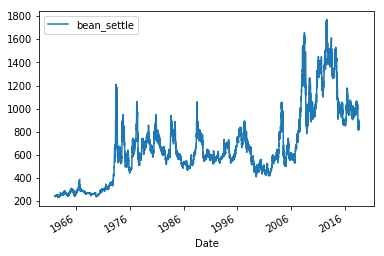

In [2]:
soybean = pd.read_csv('ALL_Prices_soybean.csv', index_col = 'Date', parse_dates=True).sort_index()
# soybean price plot
soybean.plot(y='bean_settle')

In [3]:
# examine NA
soybean.isna().sum(axis=0)

soux_H                  0
soux_L                  0
indianap_H              0
indianap_L              0
memphis_H               0
memphis_L               0
Gold                    0
USD                     0
Oil                     0
bean_high               0
bean_low                0
bean_settle             0
bean_volume             0
bean_openint            0
meal_high               0
meal_low                0
meal_settle             0
meal_volume             0
meal_openint            0
soyoil_high             0
soyoil_low              0
soyoil_settle           0
soyoil_volume           0
soyoil_openint          0
US_Area                 0
US_Production           0
Brazil_Area             0
Brazil_Production       0
Argentina_Area          0
Argentina_Production    0
China_Area              0
China_Production        0
India_Area              0
India_Production        0
Paraguay_Area           0
Paraguay_Production     0
Canada_Area             0
Canada_Production       0
RussianF_Are

In [4]:
# describe soybean
soybean.describe()

,soux_H,soux_L,indianap_H,indianap_L,memphis_H,memphis_L,Gold,USD,Oil,bean_high,...,Canada_Production,RussianF_Area,RussianF_Production,CentAmer_Area,CentAmer_Production,Bolivia_Area,Bolivia_Production,Africa_Area,Africa_Production,Market_Open
count,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,...,1.427100e+04,1.427100e+04,1.427100e+04,1.427100e+04,1.427100e+04,1.427100e+04,1.427100e+04,14271.000000,1.427100e+04,14271.0
mean,57.288347,35.248896,62.221428,41.952631,72.492537,53.543410,462.900825,96.908653,31.962378,669.663952,...,8.508928e+05,4.130463e+06,4.359434e+06,8.096050e+06,1.124243e+07,7.670896e+05,7.664331e+05,210125.173324,3.828208e+05,1.0
std,24.024862,22.096504,20.782429,18.751467,17.394332,16.895488,431.272162,13.838929,30.573479,307.879702,...,1.047529e+06,4.122183e+06,4.759663e+06,9.519903e+05,3.226929e+06,4.335542e+05,6.984126e+05,131319.257131,2.494045e+05,0.0
min,-16.000000,-36.000000,-11.000000,-28.000000,6.000000,-13.000000,35.100000,68.013700,2.304000,233.400000,...,7.306700e+04,1.100000e+04,5.000000e+03,6.507748e+06,6.205709e+06,3.178800e+05,2.795360e+05,27326.000000,5.625800e+04,1.0
25%,38.000000,20.000000,45.000000,28.000000,60.000000,40.000000,151.800000,87.154550,14.320000,491.685000,...,1.774830e+05,1.250000e+05,1.230000e+05,7.258333e+06,8.333271e+06,6.453700e+05,5.053600e+05,93181.000000,1.811810e+05,1.0
50%,61.000000,36.000000,65.000000,43.000000,75.000000,55.000000,356.850000,96.632400,19.800000,610.000000,...,5.420180e+05,2.564200e+06,2.492000e+06,8.063021e+06,1.162889e+07,6.453700e+05,5.053600e+05,173273.000000,2.948410e+05,1.0
75%,78.000000,54.000000,80.000000,58.000000,87.000000,69.000000,486.200000,108.224200,40.460800,809.500000,...,1.173356e+06,7.571200e+06,7.818900e+06,8.719719e+06,1.448540e+07,6.453700e+05,5.542360e+05,311995.000000,5.846570e+05,1.0
max,110.000000,80.000000,106.000000,77.000000,107.000000,84.000000,1895.000000,148.124400,144.760000,1773.500000,...,8.000000e+06,1.171643e+07,1.548150e+07,1.004962e+07,1.740178e+07,2.141214e+06,3.135177e+06,512786.000000,1.041330e+06,1.0


In [5]:
# drop duplicates
soybean.drop_duplicates(inplace=True)
# Market_Open = 1
soybean = soybean.loc[soybean['Market_Open'] == 1]

## Feature engineering

In [6]:
lag_feature = ['bean_high', 'bean_low', 'bean_settle']
for var in lag_feature:
    soybean[var+'_lag'] = soybean[var].shift(1)

In [7]:
rolling_feature = ['bean_settle']
rolling_wins = [5, 10, 20, 60]
for var in rolling_feature:
    for num in rolling_wins:
        soybean[var+str(num)] = soybean[var].rolling(num).aggregate(np.mean)

lag_feature = ['bean_settle5', 'bean_settle10', 'bean_settle20', 'bean_settle60',
               'Gold', 'USD', 'Oil']
for var in lag_feature:
    soybean[var] = soybean[var].shift(1)
# validate
soybean.filter(regex='bean_settle*', axis=1).head(25)   

,bean_settle,bean_settle_lag,bean_settle5,bean_settle10,bean_settle20,bean_settle60
Date,,,,,,
1962-01-02,245.0,NaN,NaN,NaN,NaN,NaN
1962-01-03,244.7,245.0,NaN,NaN,NaN,NaN
1962-01-04,243.5,244.7,NaN,NaN,NaN,NaN
1962-01-05,243.7,243.5,NaN,NaN,NaN,NaN
1962-01-08,243.7,243.7,NaN,NaN,NaN,NaN
1962-01-09,243.3,243.7,244.12,NaN,NaN,NaN
1962-01-10,242.7,243.3,243.78,NaN,NaN,NaN
1962-01-11,243.1,242.7,243.38,NaN,NaN,NaN
1962-01-12,243.7,243.1,243.30,NaN,NaN,NaN


In [8]:
# drop leaked info 
dump = ['Market_Open', 
        'bean_high', 'bean_low', 'bean_volume', 'bean_openint',
        'meal_high', 'meal_low', 'meal_settle', 'meal_volume', 'meal_openint',
        'soyoil_high', 'soyoil_low', 'soyoil_settle', 'soyoil_volume', 'soyoil_openint']
soybean.drop(columns=dump, inplace=True)

In [9]:
# numerical variables for standscaling purpose
numerical = list(soybean.columns)
numerical.remove('bean_settle')

In [10]:
# create datetime flags
soybean['wday'] = soybean.index.weekday
soybean['week'] = soybean.index.week
soybean['month'] = soybean.index.month
soybean['quarter'] = soybean.index.quarter
soybean['year'] = soybean.index.year

# convert categorical variables to dummies
data = pd.get_dummies(soybean, columns=['wday', 'week', 'month', 'quarter'])

## Split data

In [11]:
train = data[(data.index < '2018-01-01') & (data.index > '2000-01-01')]
test = data[data.index >= '2018-01-01']

# create X_train/test, Y_train/test
x_train, y_train = train.drop('bean_settle', axis=1), train['bean_settle']
x_test, y_test = test.drop('bean_settle', axis=1), test['bean_settle']

In [12]:
#StandardScaling applied to numerical variables
scale_set = [x_train, x_test]
for dataset in scale_set:
    StdScaler = StandardScaler()
    dataset.loc[:, numerical] = StdScaler.fit_transform(dataset.loc[:, numerical])

In [13]:
dataset.head()

,soux_H,soux_L,indianap_H,indianap_L,memphis_H,memphis_L,Gold,USD,Oil,US_Area,...,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,-1.533255,-2.577406,-2.680481,-2.754708,-2.621989,-2.477857,-0.021932,-0.264990,-1.259472,-1.0,...,0,0,0,0,0,0,1,0,0,0
2018-01-03,-1.769894,-1.720364,-2.452567,-2.707636,-2.129029,-2.100598,0.411288,-0.372310,-1.172482,-1.0,...,0,0,0,0,0,0,1,0,0,0
2018-01-04,-1.927654,-1.679552,-1.996740,-2.095695,-2.457669,-2.046703,0.469943,-0.281413,-1.174656,-1.0,...,0,0,0,0,0,0,1,0,0,0
2018-01-05,-1.967094,-1.434683,-2.133488,-2.378129,-1.800389,-2.100598,0.461710,-0.325932,-0.881064,-1.0,...,0,0,0,0,0,0,1,0,0,0
2018-01-08,-0.744457,-0.985756,-1.312999,-1.436682,-1.526523,-0.753243,0.516249,-0.397461,-0.863666,-1.0,...,0,0,0,0,0,0,1,0,0,0


## Modeling

### Ridge Regression

In [15]:
# Grid Search
param_set = {'alpha': 10.0**np.arange(-5, 5, 1)}
gsearch = GridSearchCV(estimator = Ridge(),
                       param_grid = param_set,
                       scoring = 'neg_mean_squared_error', cv=5)

gsearch.fit(x_train, y_train)
print(gsearch.best_params_, -gsearch.best_score_.round(2)) 

# Cross Validate
scores = cross_validate(gsearch.best_estimator_, x_train, y_train, cv=5,
                         scoring=('r2', 'neg_mean_squared_error'),
                         return_train_score=True)
print("train CV MSE: ", -scores['train_neg_mean_squared_error'].round(2), -scores['train_neg_mean_squared_error'].std())
print("validate CV MSE: ", -scores['test_neg_mean_squared_error'].round(2), -scores['test_neg_mean_squared_error'].std())
print("Train r2: ", scores['train_r2'])

{'alpha': 1e-05} 332.05
train CV MSE:  [356.57 323.33 205.99 266.04 314.72] -52.4016063370945
validate CV MSE:  [ 57.46 195.65 688.21 457.83 261.11] -219.8683056174995
Train r2:  [0.99590719 0.99721543 0.99838032 0.99610585 0.99769628]


In [16]:
# performance evaluation
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

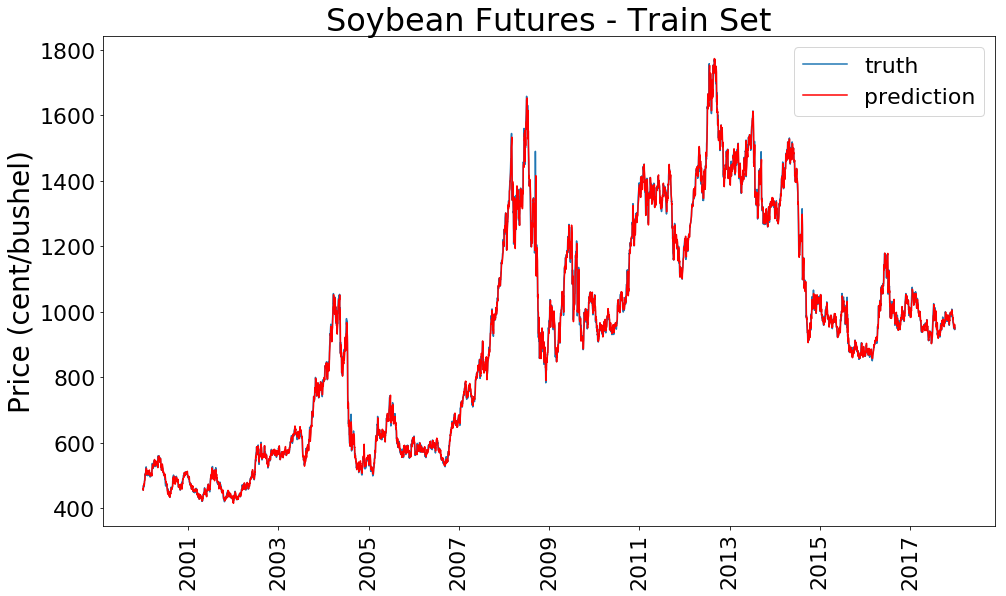

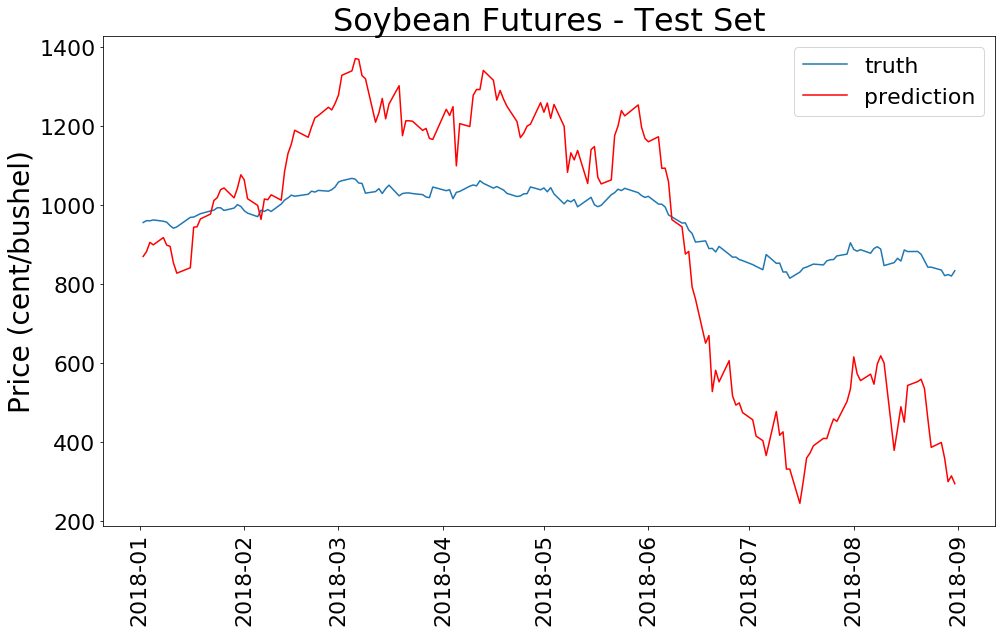

Train MSE: 295.27 and MAPE: 1.19%
Test MSE: 69678.90 and MAPE: 24.03%


In [17]:
# train set
y_train_hat = DataFrame(gsearch.best_estimator_.predict(x_train), index=x_train.index)
mse_train = metrics.mean_squared_error(y_train, y_train_hat[0])
mape_train = mean_absolute_percentage_error(y_train, y_train_hat[0])

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(16,9))
plt.plot(y_train, label='truth'); plt.plot(y_train_hat, 'r-', label='prediction')
plt.ylabel('Price (cent/bushel)', fontsize=28); plt.xticks(rotation=90)
plt.title('Soybean Futures - Train Set', fontsize=32); plt.legend(loc='best')
plt.show()

# test set
y_test_hat = DataFrame(gsearch.best_estimator_.predict(x_test), index=x_test.index)
mse_test = metrics.mean_squared_error(y_test, y_test_hat[0])
mape_test = mean_absolute_percentage_error(y_test, y_test_hat[0])

plt.figure(figsize=(16,9))
plt.plot(y_test, label='truth'); plt.plot(y_test_hat, 'r-', label='prediction')
plt.ylabel('Price (cent/bushel)', fontsize=28); plt.xticks(rotation=90)
plt.title('Soybean Futures - Test Set', fontsize=32); plt.legend(loc='best')
plt.show()

print("Train MSE: {:.2f} and MAPE: {:.2f}%".format(mse_train, mape_train))
print("Test MSE: {:.2f} and MAPE: {:.2f}%".format(mse_test, mape_test))

Ridge regression output indicates overfitting!

### Random Forest

In [18]:
param_set = {'n_estimators': range(10, 50, 10)}
gsearch = GridSearchCV(estimator = RandomForestRegressor(),
                       param_grid = param_set,
                       scoring = 'neg_mean_squared_error', cv=10)

gsearch.fit(x_train, y_train)
print(gsearch.best_params_, -gsearch.best_score_.round(2)) 

# cross validate
scores = cross_validate(gsearch.best_estimator_, x_train, y_train, cv=5,
                         scoring=('r2', 'neg_mean_squared_error'),
                         return_train_score=True)
print("train CV MSE: ", -scores['train_neg_mean_squared_error'].round(2), -scores['train_neg_mean_squared_error'].std())
print("validate CV MSE: ", -scores['test_neg_mean_squared_error'].round(2), -scores['test_neg_mean_squared_error'].std())
print("Train r2: ", scores['train_r2'])

{'n_estimators': 40} 397.91
train CV MSE:  [58.32 53.74 36.92 47.71 54.92] -7.525646382124585
validate CV MSE:  [1490.25 1574.3   739.85 1978.24  285.58] -612.6937030752802
Train r2:  [0.99933056 0.99953716 0.99970967 0.99930157 0.99959796]


In [19]:
# feature_importances
rf = RandomForestRegressor(n_estimators = 40)
rf.fit(x_train, y_train)
x_train.columns[rf.feature_importances_.argsort()[-1:-11:-1]]

Index(['bean_settle_lag', 'bean_low_lag', 'bean_high_lag', 'Gold',
       'bean_settle5', 'bean_settle20', 'Oil', 'bean_settle60', 'USD',
       'bean_settle10'],
      dtype='object')

Top 10 importantce features by RandomForest regressor result

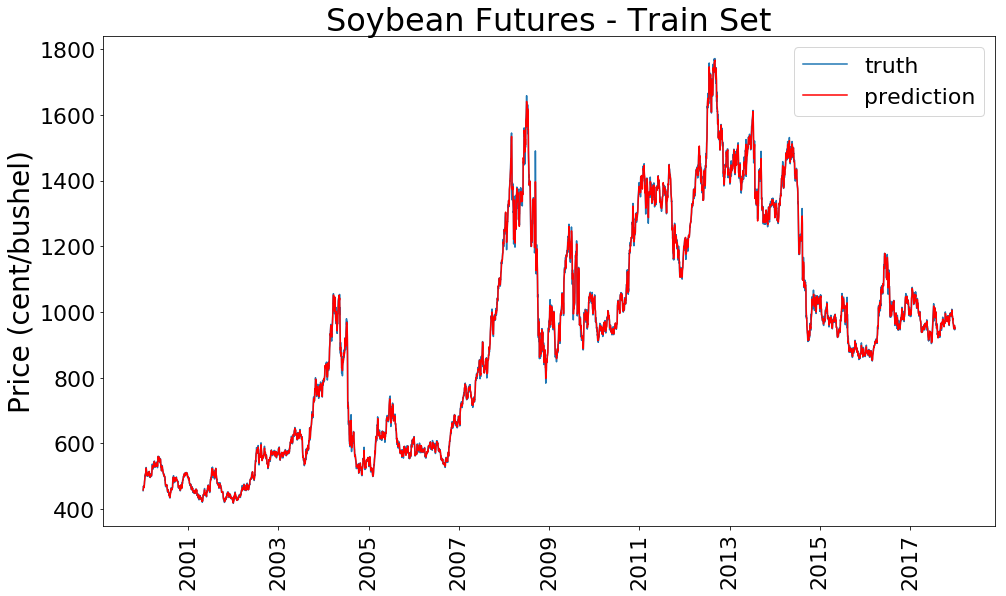

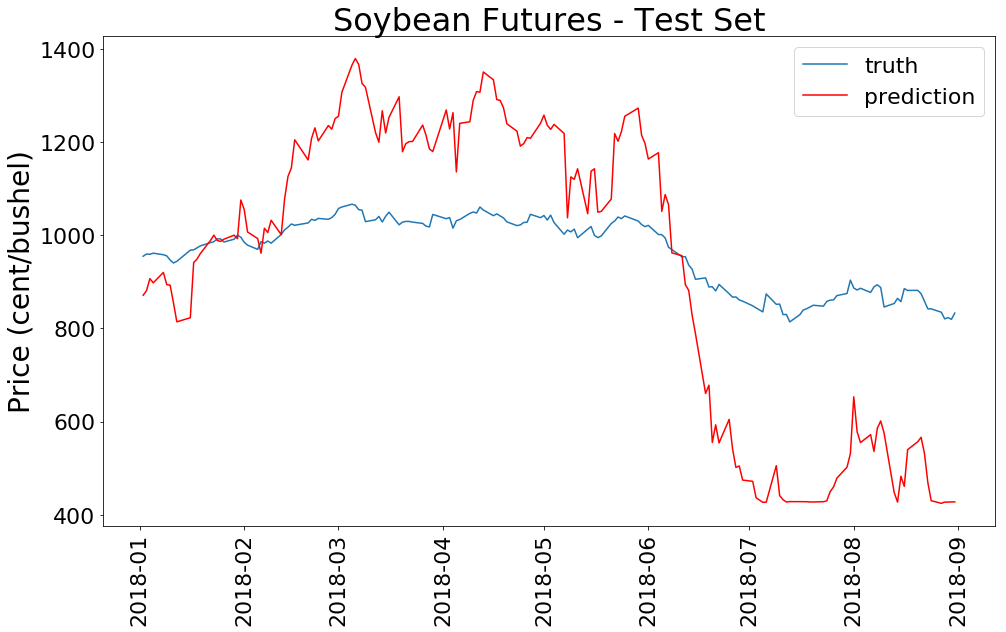

Train MSE: 48.95 and MAPE: 0.47%
Test MSE: 62055.09 and MAPE: 22.94%


In [20]:
# train set
y_train_hat = DataFrame(gsearch.best_estimator_.predict(x_train), index=x_train.index)
mse_train = metrics.mean_squared_error(y_train, y_train_hat[0])
mape_train = mean_absolute_percentage_error(y_train, y_train_hat[0])

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(16,9))
plt.plot(y_train, label='truth'); plt.plot(y_train_hat, 'r-', label='prediction')
plt.ylabel('Price (cent/bushel)', fontsize=28); plt.xticks(rotation=90)
plt.title('Soybean Futures - Train Set', fontsize=32); plt.legend(loc='best')
plt.show()

# test set
y_test_hat = DataFrame(gsearch.best_estimator_.predict(x_test), index=x_test.index)
mse_test = metrics.mean_squared_error(y_test, y_test_hat[0])
mape_test = mean_absolute_percentage_error(y_test, y_test_hat[0])

plt.figure(figsize=(16,9))
plt.plot(y_test, label='truth'); plt.plot(y_test_hat, 'r-', label='prediction')
plt.ylabel('Price (cent/bushel)', fontsize=28); plt.xticks(rotation=90)
plt.title('Soybean Futures - Test Set', fontsize=32); plt.legend(loc='best')
plt.show()

print("Train MSE: {:.2f} and MAPE: {:.2f}%".format(mse_train, mape_train))
print("Test MSE: {:.2f} and MAPE: {:.2f}%".format(mse_test, mape_test))

## Short summary

Both Ridge and RandomForest indicate overfitting the training set!
Next step will try just using important features to reduce predictor variables to see any improvement on overfitting.

In [21]:
soybean.columns

Index(['soux_H', 'soux_L', 'indianap_H', 'indianap_L', 'memphis_H',
       'memphis_L', 'Gold', 'USD', 'Oil', 'bean_settle', 'US_Area',
       'US_Production', 'Brazil_Area', 'Brazil_Production', 'Argentina_Area',
       'Argentina_Production', 'China_Area', 'China_Production', 'India_Area',
       'India_Production', 'Paraguay_Area', 'Paraguay_Production',
       'Canada_Area', 'Canada_Production', 'RussianF_Area',
       'RussianF_Production', 'CentAmer_Area', 'CentAmer_Production',
       'Bolivia_Area', 'Bolivia_Production', 'Africa_Area',
       'Africa_Production', 'bean_high_lag', 'bean_low_lag', 'bean_settle_lag',
       'bean_settle5', 'bean_settle10', 'bean_settle20', 'bean_settle60',
       'wday', 'week', 'month', 'quarter', 'year'],
      dtype='object')

## Reduce features 

In [22]:
keep = ['bean_settle',
        'bean_settle_lag', 'bean_high_lag', 'bean_low_lag', 'bean_settle5', 'bean_settle10', 'bean_settle20', 'bean_settle60',
        'Gold', 'USD', 'Oil',
        'wday', 'week', 'month', 'quarter', 'year']    
soybean = soybean.filter(items=keep)

In [24]:
soybean['wday'] = soybean.index.weekday
soybean['week'] = soybean.index.week
soybean['month'] = soybean.index.month
soybean['quarter'] = soybean.index.quarter
soybean['year'] = soybean.index.year

# convert categorical variables to dummies
data = pd.get_dummies(soybean, columns=['wday', 'week', 'month', 'quarter']) 

In [25]:
data.head()

,bean_settle,bean_settle_lag,bean_high_lag,bean_low_lag,bean_settle5,bean_settle10,bean_settle20,bean_settle60,Gold,USD,...,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,245.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
1962-01-03,244.7,245.0,245.0,243.6,NaN,NaN,NaN,NaN,35.2,108.2242,...,0,0,0,0,0,0,1,0,0,0
1962-01-04,243.5,244.7,245.3,244.3,NaN,NaN,NaN,NaN,35.2,108.2242,...,0,0,0,0,0,0,1,0,0,0
1962-01-05,243.7,243.5,245.1,243.4,NaN,NaN,NaN,NaN,35.2,108.2242,...,0,0,0,0,0,0,1,0,0,0
1962-01-08,243.7,243.7,244.0,243.2,NaN,NaN,NaN,NaN,35.2,108.2242,...,0,0,0,0,0,0,1,0,0,0


## Split data

In [29]:
data.columns

Index(['bean_settle', 'bean_settle_lag', 'bean_high_lag', 'bean_low_lag',
       'bean_settle5', 'bean_settle10', 'bean_settle20', 'bean_settle60',
       'Gold', 'USD', 'Oil', 'year', 'wday_0', 'wday_1', 'wday_2', 'wday_3',
       'wday_4', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6',
       'week_7', 'week_8', 'week_9', 'week_10', 'week_11', 'week_12',
       'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18',
       'week_19', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24',
       'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_30',
       'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36',
       'week_37', 'week_38', 'week_39', 'week_40', 'week_41', 'week_42',
       'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48',
       'week_49', 'week_50', 'week_51', 'week_52', 'week_53', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'mo

In [43]:
train = data[(data.index < '2018-01-01') & (data.index > '2000-01-01')]
test = data[data.index >= '2018-01-01']

x_train, y_train = train.drop('bean_settle', axis=1), train['bean_settle']
x_test, y_test = test.drop('bean_settle', axis=1), test['bean_settle']

### Ridge regression

In [44]:
param_set = {'alpha': 10.0**np.arange(-5, 5, 1)}
gsearch = GridSearchCV(estimator = Ridge(),
                       param_grid = param_set,
                       scoring = 'neg_mean_squared_error', cv=5)

gsearch.fit(x_train, y_train)
print(gsearch.best_params_, -gsearch.best_score_.round(2)) 

# cross validate
scores = cross_validate(gsearch.best_estimator_, x_train, y_train, cv=5,
                         scoring=('r2', 'neg_mean_squared_error'),
                         return_train_score=True)
print("train CV MSE: ", -scores['train_neg_mean_squared_error'].round(2), -scores['train_neg_mean_squared_error'].std())
print("validate CV MSE: ", -scores['test_neg_mean_squared_error'].round(2), -scores['test_neg_mean_squared_error'].std())
print("Train r2: ", scores['train_r2'])

{'alpha': 10000.0} 311.19
train CV MSE:  [373.07 337.95 215.1  276.93 328.92] -55.04786203742037
validate CV MSE:  [ 41.25 186.45 680.06 429.26 218.91] -222.24062945007657
Train r2:  [0.99571782 0.9970895  0.99830871 0.99594641 0.99759239]


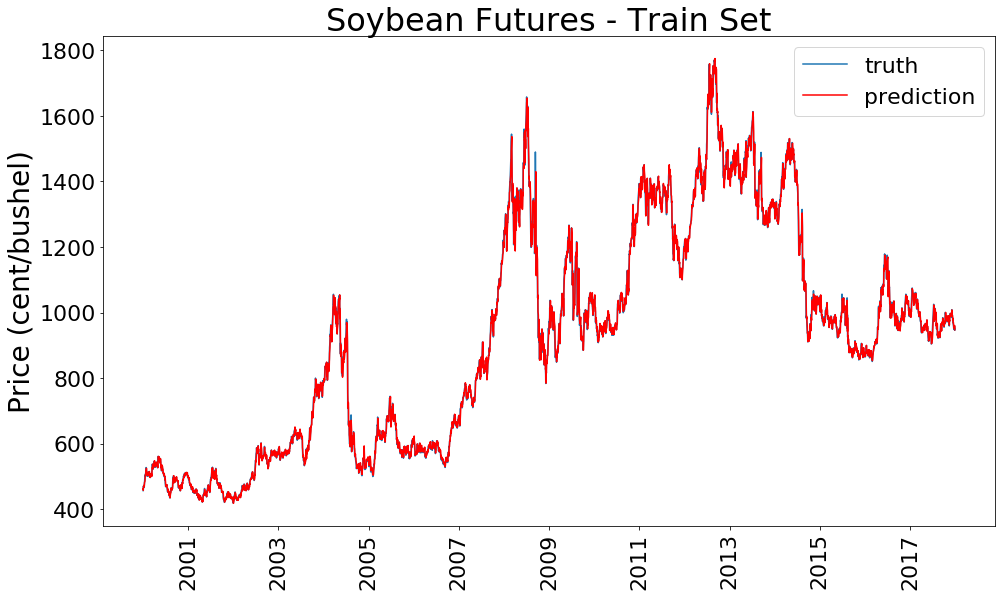

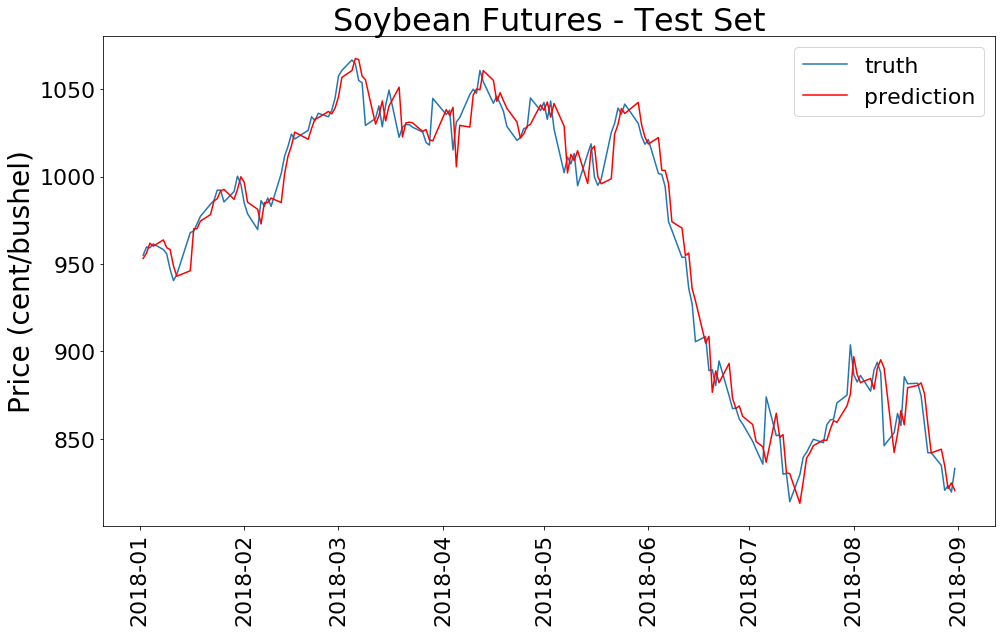

Train MSE: 306.70 and MAPE: 1.18%
Test MSE: 137.73 and MAPE: 0.93%


In [45]:
y_train_hat = DataFrame(gsearch.best_estimator_.predict(x_train), index=x_train.index)
mse_train = metrics.mean_squared_error(y_train, y_train_hat[0])
mape_train = mean_absolute_percentage_error(y_train, y_train_hat[0])

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(16,9))
plt.plot(y_train, label='truth'); plt.plot(y_train_hat, 'r-', label='prediction')
plt.ylabel('Price (cent/bushel)', fontsize=28); plt.xticks(rotation=90)
plt.title('Soybean Futures - Train Set', fontsize=32); plt.legend(loc='best')
plt.show()

# test set
y_test_hat = DataFrame(gsearch.best_estimator_.predict(x_test), index=x_test.index)
mse_test = metrics.mean_squared_error(y_test, y_test_hat[0])
mape_test = mean_absolute_percentage_error(y_test, y_test_hat[0])

plt.figure(figsize=(16,9))
plt.plot(y_test, label='truth'); plt.plot(y_test_hat, 'r-', label='prediction')
plt.ylabel('Price (cent/bushel)', fontsize=28); plt.xticks(rotation=90)
plt.title('Soybean Futures - Test Set', fontsize=32); plt.legend(loc='best')
plt.show()

print("Train MSE: {:.2f} and MAPE: {:.2f}%".format(mse_train, mape_train))
print("Test MSE: {:.2f} and MAPE: {:.2f}%".format(mse_test, mape_test))

### RandomForest 

In [46]:
param_set = {'n_estimators': range(10, 50, 10)}
gsearch = GridSearchCV(estimator = RandomForestRegressor(),
                       param_grid = param_set,
                       scoring = 'neg_mean_squared_error', cv=10)

gsearch.fit(x_train, y_train)
print(gsearch.best_params_, -gsearch.best_score_.round(2)) 

# cross validate
scores = cross_validate(gsearch.best_estimator_, x_train, y_train, cv=5,
                         scoring=('r2', 'neg_mean_squared_error'),
                         return_train_score=True)
print("train CV MSE: ", -scores['train_neg_mean_squared_error'].round(2), -scores['train_neg_mean_squared_error'].std())
print("validate CV MSE: ", -scores['test_neg_mean_squared_error'].round(2), -scores['test_neg_mean_squared_error'].std())
print("Train r2: ", scores['train_r2'])

{'n_estimators': 40} 398.71
train CV MSE:  [58.36 56.41 35.78 42.42 51.41] -8.55731008231411
validate CV MSE:  [1498.93 1182.08  761.76 1551.36  269.76] -482.11321418333586
Train r2:  [0.99933016 0.99951423 0.99971867 0.99937902 0.99962371]


In [47]:
# feature_importances
rf = RandomForestRegressor(n_estimators = 40)
rf.fit(x_train, y_train)
x_train.columns[rf.feature_importances_.argsort()[-1:-11:-1]]

Index(['bean_settle_lag', 'bean_high_lag', 'bean_low_lag', 'Gold',
       'bean_settle5', 'USD', 'bean_settle20', 'Oil', 'bean_settle10',
       'bean_settle60'],
      dtype='object')

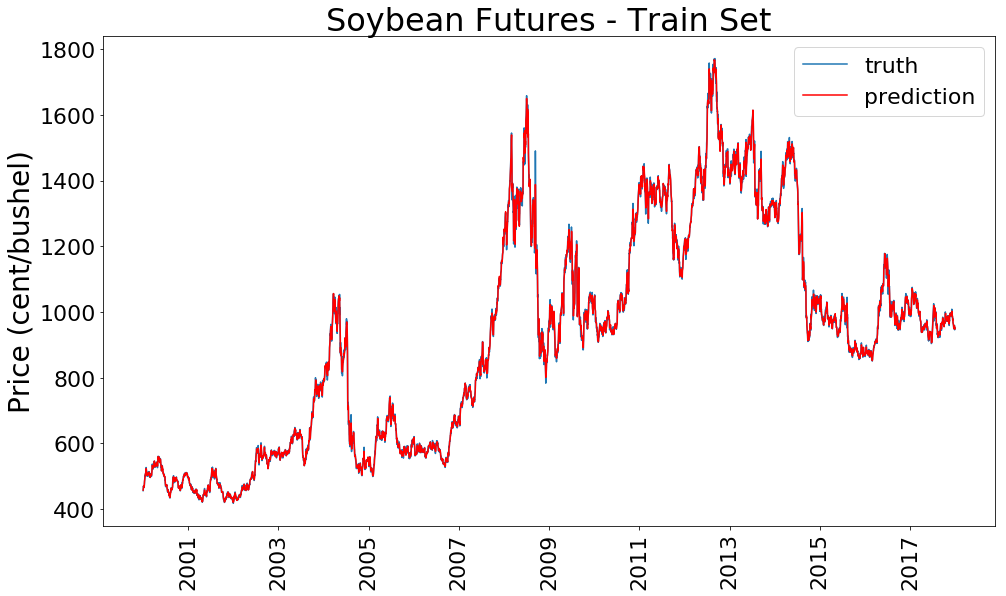

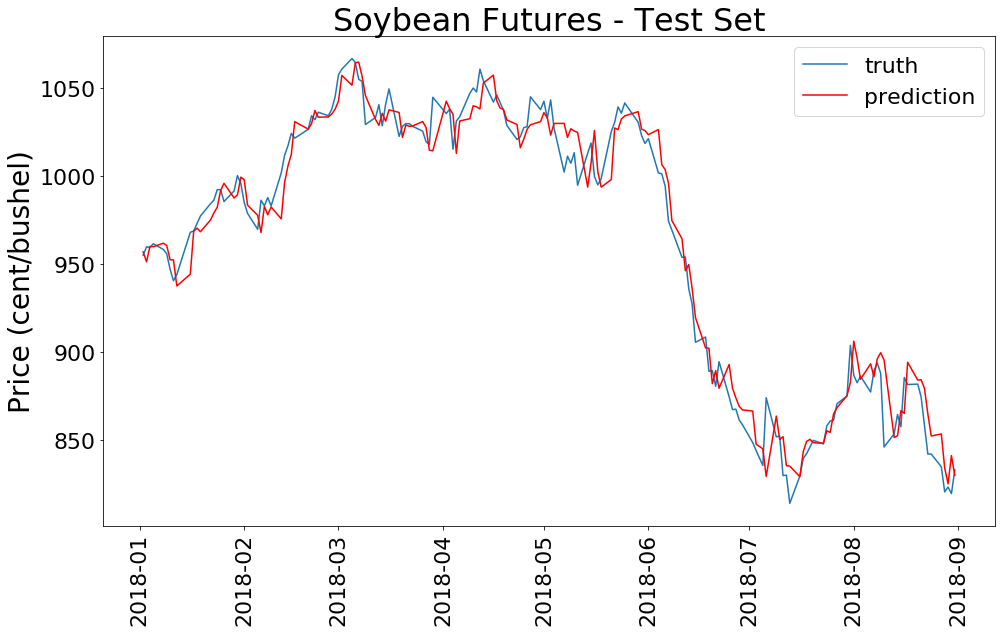

Train MSE: 49.87 and MAPE: 0.47%
Test MSE: 161.23 and MAPE: 1.01%


In [48]:
y_train_hat = DataFrame(gsearch.best_estimator_.predict(x_train), index=x_train.index)
mse_train = metrics.mean_squared_error(y_train, y_train_hat[0])
mape_train = mean_absolute_percentage_error(y_train, y_train_hat[0])

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(16,9))
plt.plot(y_train, label='truth'); plt.plot(y_train_hat, 'r-', label='prediction')
plt.ylabel('Price (cent/bushel)', fontsize=28); plt.xticks(rotation=90)
plt.title('Soybean Futures - Train Set', fontsize=32); plt.legend(loc='best')
plt.show()

# test set
y_test_hat = DataFrame(gsearch.best_estimator_.predict(x_test), index=x_test.index)
mse_test = metrics.mean_squared_error(y_test, y_test_hat[0])
mape_test = mean_absolute_percentage_error(y_test, y_test_hat[0])

plt.figure(figsize=(16,9))
plt.plot(y_test, label='truth'); plt.plot(y_test_hat, 'r-', label='prediction')
plt.ylabel('Price (cent/bushel)', fontsize=28); plt.xticks(rotation=90)
plt.title('Soybean Futures - Test Set', fontsize=32); plt.legend(loc='best')
plt.show()

print("Train MSE: {:.2f} and MAPE: {:.2f}%".format(mse_train, mape_train))
print("Test MSE: {:.2f} and MAPE: {:.2f}%".format(mse_test, mape_test))

## Conclusion

As we can see, after removing lots of useless features, the tendency of overfitting is largely reduced.

For training, RandomForest outperforms Ridge that means RandomForest fits data better.
For test, RandomForest loses Ridge a bit. In my view, I would explain this phenomenon as because RandomForest fits training set much well.